In [1]:
from qiskit_aqua.algorithms.single_sample import AmplitudeEstimation
from qiskit_aqua.algorithms.components.uncertainty_problems import EuropeanCallExpectedValue
from qiskit_aqua.algorithms.components.uncertainty_problems import EuropeanCallDelta
from qiskit_aqua.algorithms.components.uncertainty_models.log_normal_distribution import LogNormalDistribution
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import execute, ClassicalRegister

# Analysis of European Call Option
<br>
Suppose a European option with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:
<br>
<br>
$$\max\{S - K, 0\}$$
<br>
In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price for the option:
<br>
<br>
$$p = \mathbb{E}\left[ \max\{S - K, 0\} \right]$$
<br>
as well as the corresponding $\Delta$, i.e., the derivative of the option price with respect to the spot price, defined as:
<br>
<br>
$$
\Delta = \mathbb{P}\left[S \geq K\right]
$$

## Uncertainty Model

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 2

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = 1
high = 2**num_uncertainty_qubits

# parameters for considered random distribution
mu = 1.5
sigma = 1

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma, low=low, high=high)

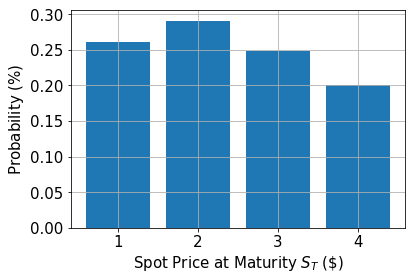

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y)
plt.xticks(x, size=15)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

## Payoff Function

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.5

# construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    uncertainty_model,
    strike_price=strike_price,
    c_approx=c_approx
)

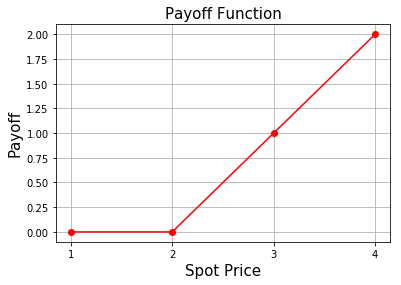

In [5]:
# plot payoff function
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x)
plt.show()

In [6]:
# evaluate exact expected value 
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print('exact (normalized) expected value:\t%.4f' % exact_value)
print('exact (normalized) delta value:   \t%.4f' % exact_delta)

exact (normalized) expected value:	0.6478
exact (normalized) delta value:   	0.7385


## Evaluate Expected Payoff

In [7]:
# set number of evaluation qubits (samples)
m = 5

# construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)

In [8]:
# get quantum circuit for amplitude estimation
qc = ae.construct_circuit()

In [9]:
# run circuit on statevector simulator
import qiskit
state_vector = np.asarray(execute(qc, qiskit.Aer.get_backend('statevector_simulator_py')).result().get_statevector(qc))

state_probabilities = np.real(state_vector.conj() * state_vector)

In [10]:
# # run circuit on QASM simulator
# cr = ClassicalRegister(m)
# qc.add_register(cr)
# qc.measure([q for q in qc.qregs if q.name == 'a'][0], cr)
# shots = 100
# results = execute(qc, shots=shots, backend=qiskit.Aer.get_backend('qasm_simulator_py'))
# print(results.result().get_counts())
# y_items = []
# for state, counts in results.result().get_counts().items():
#     y_items += [(int(state[:m][::-1], 2), counts/shots)]

In [11]:
# evaluate results
a_probabilities, y_probabilities = ae.evaluate_results(state_probabilities)

a_items = [(a, p) for (a, p) in a_probabilities.items() if p > 1e-6]
y_items = [(y, p) for (y, p) in y_probabilities.items() if p > 1e-6]
a_items = sorted(a_items)
y_items = sorted(y_items)

# map estimated values to original range and extract probabilities
mapped_values = [european_call.value_to_estimator(a_item[0]) for a_item in a_items]
values = [a_item[0] for a_item in a_items]
y_values = [y_item[0] for y_item in y_items]
probabilities = [a_item[1] for a_item in a_items]
mapped_items = [(mapped_values[i], probabilities[i]) for i in range(len(mapped_values))]

# determine most likely estimator
estimator = None
max_prob = 0
for val, prob in mapped_items:
    if prob > max_prob:
        max_prob = prob
        estimator = val
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % estimator)
print('Probability:    \t%.4f' % max_prob)

Exact value:    	0.6478
Estimated value:	0.7516
Probability:    	0.7652


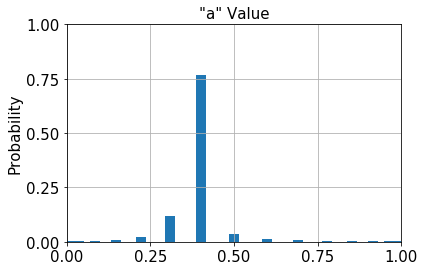

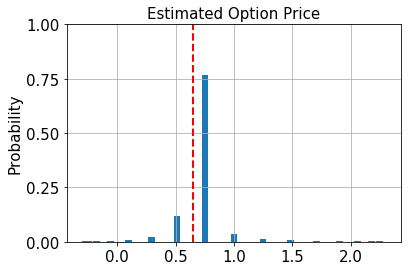

In [12]:
# plot estimated values for "a"
plt.bar(values, probabilities, width=0.5/len(probabilities))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price
plt.bar(mapped_values, probabilities, width=1/len(probabilities))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

## Evaluate Delta

In [13]:
european_call_delta = EuropeanCallDelta(
    uncertainty_model,
    strike_price
)

In [14]:
# set number of evaluation qubits (samples)
m = 5

# construct amplitude estimation 
ae_delta = AmplitudeEstimation(m, european_call_delta)

In [15]:
# get quantum circuit for amplitude estimation
qc = ae_delta.construct_circuit()

In [16]:
# run circuit
state_vector = np.asarray(execute(qc, qiskit.Aer.get_backend('statevector_simulator_py')).result().get_statevector(qc))
state_probabilities = np.real(state_vector.conj() * state_vector)

In [17]:
# evaluate results
a_probabilities, y_probabilities = ae_delta.evaluate_results(state_probabilities)

a_items = [(a, p) for (a, p) in a_probabilities.items() if p > 1e-6]
y_items = [(y, p) for (y, p) in y_probabilities.items() if p > 1e-6]
a_items = sorted(a_items)
y_items = sorted(y_items)

# map estimated values to original range and extract probabilities
mapped_values = [a_item[0] for a_item in a_items]
values = [a_item[0] for a_item in a_items]
probabilities = [a_item[1] for a_item in a_items]
mapped_items = [(mapped_values[i], probabilities[i]) for i in range(len(mapped_values))]

# determine most likely estimator
estimator = None
max_prob = 0
for val, prob in mapped_items:
    if prob > max_prob:
        max_prob = prob
        estimator = val
print('Exact delta:   \t%.4f' % exact_delta)
print('Esimated value:\t%.4f' % estimator)
print('Probability:   \t%.4f' % max_prob)

Exact delta:   	0.7385
Esimated value:	0.7778
Probability:   	0.4609


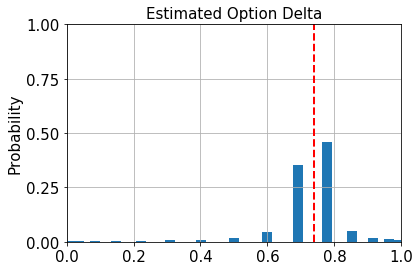

In [18]:
# plot estimated values for delta
plt.bar(values, probabilities, width=0.5/len(probabilities))
plt.plot([exact_delta, exact_delta], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Delta', size=15)
plt.ylabel('Probability', size=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()